## Example 7.
### Sensitivity of hydraulic head at a point to <font color='blue'>Cauchy BC conductance</font> under steady state flow conditions

## 0. Forward model
<br>
Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d^2h}{dx^2}+R=0\cr
\cr\end{align}$

Boundary conditions:

$\begin{align}
\quad\quad -K\ b\ \frac{dh(x)}{dx}=0\ ,\quad\quad\quad\quad\quad\quad\;\, x=0\cr
\end{align}$

$\begin{align}
\quad\quad -K\ b\ \frac{dh(x)}{dx}=C\ [h^*-h(x)]\ ,\quad\quad x=L\cr
\cr\end{align}$

Closed-form solution:

$\begin{align}
\quad\quad\rm{Not\ available}
\cr\cr\end{align}$

Spatial derivatives from differentiation:

$\begin{align}
\quad\quad\rm{Not\ available}
\cr\end{align}$

In [67]:
from IPython.display import HTML, display
def set_background(color):
    script = (
        "var cell = this.closest('.code_cell');"
        "var editor = cell.querySelector('.input_area');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)").format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

In [68]:
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)

import numpy as np

K, R, b, L, BC3h, BC3c, ocol = 10., 1e-1/1000., 10., 10000., 1., 1., 5000
X = np.arange(L)

## 1. Direct sensitivity
$\begin{align}
\quad\quad\rm{Not\ available}
\cr\end{align}$

## 2. Perturbation sensitivity
$\begin{align}\cr
\frac{\partial h(x')}{\partial C_{\Gamma_3}}\approx\frac{h(x,C_{\Gamma_3}+\Delta C_{\Gamma_3})-h(x,C_{\Gamma_3})}{\Delta C_{\Gamma_3}}\;
\cr\cr\end{align}$

### 2a. Analytical
$\begin{align}
\quad\quad\rm{Not\ available}
\cr\end{align}$

### 2b. Semi-analytical

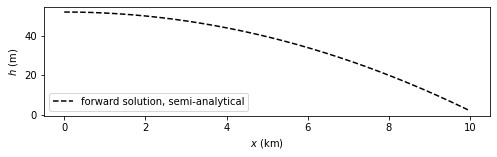

In [101]:
from os import getcwd, chdir
cwd = getcwd()
chdir(r'../../timml')
import timml
chdir(cwd)

dpar = 1e-4
M0 = timml.Model3D(kaq=K, z=[0., -b])
timml.ImpLineDoublet1D(M0, xld=0.)
timml.HeadLineSink1D(M0, xls=L, hls=BC3h, res=BC3c/100., wh=1.)
timml.StripAreaSink(M0, 0., L, R)
M0.solve(silent=True)
H0 = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend(loc=3);

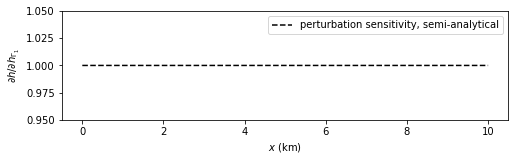

In [102]:
M1 = timml.Model3D(kaq=K, z=[0., -b])
timml.ImpLineDoublet1D(M1, xld=0.)
timml.HeadLineSink1D(M1, xls=L, hls=BC3h, res=(BC3c+BC3c*dpar)/100., wh=1.)
timml.StripAreaSink(M1, 0., L, R)
M1.solve(silent=True)
H1 = M1.headalongline(X, 0.).flatten()
dhdBC3c = (H1-H0)/(BC3h*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdBC3c, 'k--', mfc='none', label='perturbation sensitivity, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial h_{\Gamma_1}$')
plt.legend()
plt.ylim(0.95, 1.05);

In [103]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% dhdBC3c[ocol])

1.000000


## 2c. Numerical

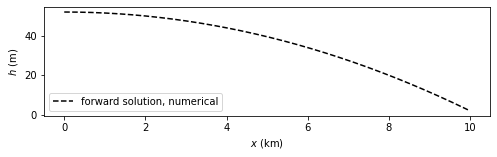

In [69]:
import flopy

dpar = 1e-3
nrow, ncol = 1, int(L)
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=nrow, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.ones([nrow, ncol]), strt=BC3h*np.ones([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowRch(M0, nrchop=1, rech=R, ipakcb=53)
flopy.modflow.ModflowGhb(M0, stress_period_data={0: [0, 0, ncol-1, BC3h, BC3c]})
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
H0 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
hBC3 = H0[-1]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend(loc=3);

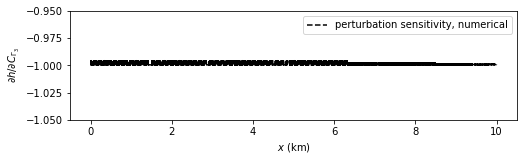

In [70]:
M1 = M0
flopy.modflow.ModflowGhb(M1, stress_period_data={0: [0, 0, ncol-1, BC3h, BC3c+BC3c*dpar]})
M1.write_input()
success, buff = M1.run_model(silent=True)
H1 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
dhdBC3c = (H1-H0)/(BC3c*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdBC3c, 'k--', mfc='none', label='perturbation sensitivity, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial C_{\Gamma_3}$')
plt.legend()
plt.ylim(-1.05, -0.95);

In [71]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% dhdBC3c[ocol])

-0.999451


## 3. Adjoint sensitivity

<br>
    
$\begin{align}
\quad\quad \frac{\partial h(x')}{\partial h_{\Gamma_3}}=\oint\limits_{\Gamma_3}\psi^*_1(x)\ [h_{\Gamma_3}-h(x)]\; dx\ =\ \psi^*_1(\Gamma_3)\ [h_{\Gamma_3}-h(\Gamma_3)]
\cr\end{align}$

Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d\psi^*_1}{dx}+\frac{1}{2\ K\ b}\delta(x-x')=0\cr
\cr\end{align}$

Boundary conditions: 

$\begin{align}
\quad\quad \psi^*_1(x)=0\ ,\quad\quad\quad\quad x=0\cr
\end{align}$

$\begin{align}
\quad\quad(\rm{undefined\ on\ }\Gamma_3)\cr
\cr\end{align}$

Closed-form solution:

$\begin{align}
\quad\quad\rm{Not\ available}
\cr\end{align}$

### 3a. Analytical
$\begin{align}
\quad\quad\rm{Not\ available}
\cr\end{align}$

### 3b. Semi-analytical

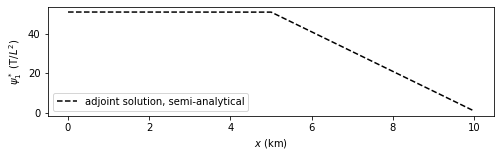

In [104]:
M0 = timml.Model3D(kaq=K, z=[0., -b])
timml.ImpLineDoublet1D(M0, xld=0.)
timml.HeadLineSink1D(M0, xls=L, hls=0., res=BC3c/100., wh=1.)
timml.LineSink1D(M0, xls=float(ocol), sigls=-1.)
M0.solve(silent=True)
A = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

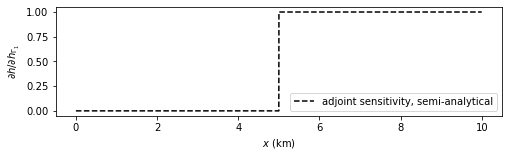

In [105]:
dhdBC3h = np.array([M0.disvec(x,0) for x in X])[:,0].flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
f,s = plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdBC3h, 'k--', mfc='none', label='adjoint sensitivity, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial h_{\Gamma_1}$')
plt.legend(loc=4);

In [107]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% dhdBC3h[-1])

1.000000


### 3c. Numerical

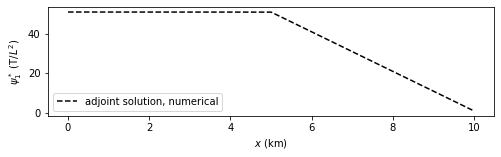

In [72]:
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=1, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.ones([nrow, ncol]), strt=BC3h*np.ones([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowGhb(M0, stress_period_data={0: [0, 0, ncol-1, 0., BC3c]})
flopy.modflow.ModflowWel(M0, stress_period_data={0: [0, 0, ocol, 1.]})
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

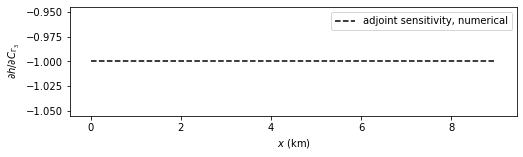

In [73]:
dhdBC3c = np.empty(0)
for oc,xp in enumerate(X[::1000]):
    M1 = M0
    flopy.modflow.ModflowWel(M1, stress_period_data={0: [0, 0, oc, 1.]})
    M1.write_input()
    success, buff = M1.run_model(silent=True)
    A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
    dhdBC3c = np.append(dhdBC3c, A[-1]*(BC3c-hBC3))

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X[::1000]/1000., dhdBC3c, 'k--', mfc='none', label='adjoint sensitivity, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial C_{\Gamma_3}$')
plt.legend();

In [74]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% dhdBC3c[int(np.where(X[::1000]==float(ocol))[0])])

-1.000000
